In [384]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

Splitting data

In [361]:
data = np.load('data.npy', allow_pickle=True)
np.random.shuffle(data)
size = math.floor(len(data) * 0.8)
train_data = data[0 : size - 1, :]
validation_data = data[size : len(data) - 1, :]

label, label_frequency = np.unique(data[:, 3], return_counts=True)

TASK 1

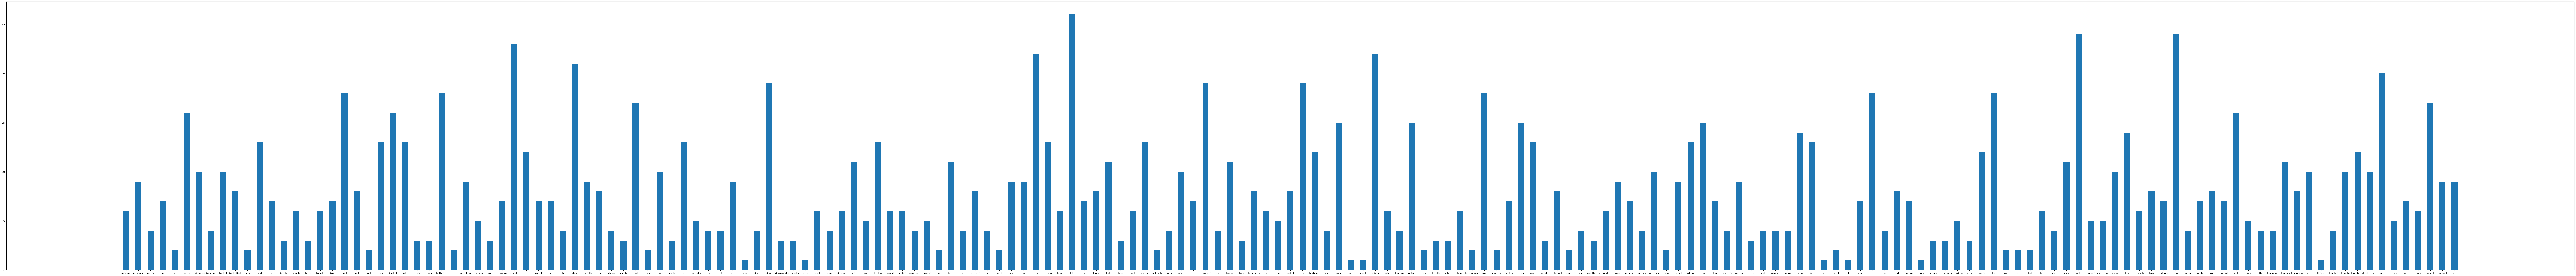

In [115]:
fig = plt.figure(figsize=(190, 20))
plt.bar(label, label_frequency, width=0.5)
plt.show()

TASK 2

In [391]:
class Knn:
    def __init__(self, k, metric, encoding):
        self.k = k
        self.metric = metric
        self.encoding = encoding

    def predict(self, enc, train_data, validation_data):
        pred = []
        for test in validation_data:
            test = test[enc][0]
            list_distance = []

            for train in train_data:
                train_enc = train[enc][0]
                distance = self.compute_distance(test, train_enc)
                list_distance.append([distance, train[3]])
                
            list_distance.sort(key=lambda x: x[0])
            list_distance = list_distance[:self.k]
            train_labels = [x[1] for x in list_distance]
            pred.append(max(set(train_labels), key = train_labels.count))

        return pred

    def find_encoding(self):
        if self.encoding == 'ResNet':
            return 1
        return 2

    def compute_distance(self, test, train_enc):
        if self.metric == 'euclidean':
            diff = np.subtract(test, train_enc)
            distance = np.sqrt(np.sum(diff * diff))
            return distance
        
        if self.metric == 'manhattan':
            diff = abs(np.subtract(test, train_enc))
            distance = np.sum(diff)
            return distance
        
        if self.metric == 'cosine':
            dot_product = np.dot(train_enc, test)
            train_enc_magnitude = np.linalg.norm(train_enc)
            test_magnitude = np.linalg.norm(test)
            similarity = dot_product / (train_enc_magnitude * test_magnitude)
            return (1 - similarity)
        
    def print_scores(self, val, pred):
        print(accuracy_score(val, pred))
        print(f1_score(val, pred, average='macro'))
        print(precision_score(val, pred, average='macro', zero_division=0))
        print(recall_score(val, pred, average='macro', zero_division=0))

    def score(self, val, pred):
        return accuracy_score(val, pred)

        

In [392]:
prev = time.time()
prediction_initial = Knn(3, metric='euclidean', encoding='ResNet')
enc = prediction_initial.find_encoding()
pred = prediction_initial.predict(enc, train_data=train_data, validation_data=validation_data)
val = validation_data[:, 3]
prediction_initial.print_scores(val, pred)
prediction_initial.score(val, pred)
curr = time.time()
time_initial = curr - prev

print()

prev = time.time()
prediction_best = Knn(17, metric='manhattan', encoding='VIT')
enc = prediction_best.find_encoding()
pred = prediction_best.predict(enc, train_data=train_data, validation_data=validation_data)
val = validation_data[:, 3]
prediction_best.print_scores(val, pred)
prediction_best.score(val, pred)
curr = time.time()
time_best = curr - prev

0.22818791946308725
0.136803095894005
0.14104683195592285
0.16473829201101928

0.2348993288590604
0.11943362193362193
0.11902777777777776
0.13847222222222222


TASK 3

In [118]:
metrics_list = ['euclidean', 'manhattan', 'cosine']
encoding_list = ['ResNet', 'VIT']

accuracy_list = []
k_list = []
acc_list = []

for k in range(1, 35):
    k_list.append(k)
    for metric in metrics_list:
        for encoding in encoding_list:  
            if encoding == 'ResNet':
                enc = 1
            else:
                enc = 2
            
            knn = Knn(k, metric, encoding)
            pred = knn.predict(enc, train_data, validation_data)
            acc = knn.score(validation_data[:, 3], pred)  
            if(metric == 'manhattan' and encoding == 'VIT'):
                acc_list.append(acc)
            
            accuracy_list.append([k, metric, encoding, acc])

accuracy_list.sort(key=lambda x: x[3], reverse=True)
for l in accuracy_list[:20]:
    print(l)

[8, 'manhattan', 'VIT', 0.26755852842809363]
[9, 'manhattan', 'VIT', 0.2608695652173913]
[5, 'manhattan', 'VIT', 0.25752508361204013]
[8, 'euclidean', 'VIT', 0.25418060200668896]
[13, 'euclidean', 'VIT', 0.25418060200668896]
[6, 'euclidean', 'VIT', 0.2508361204013378]
[7, 'euclidean', 'VIT', 0.2508361204013378]
[7, 'cosine', 'VIT', 0.2508361204013378]
[1, 'manhattan', 'VIT', 0.24749163879598662]
[4, 'manhattan', 'VIT', 0.24749163879598662]
[7, 'manhattan', 'VIT', 0.24749163879598662]
[9, 'euclidean', 'VIT', 0.24749163879598662]
[9, 'cosine', 'VIT', 0.24749163879598662]
[14, 'manhattan', 'VIT', 0.24749163879598662]
[5, 'euclidean', 'VIT', 0.24414715719063546]
[6, 'manhattan', 'VIT', 0.24414715719063546]
[10, 'euclidean', 'VIT', 0.24414715719063546]
[11, 'euclidean', 'VIT', 0.24414715719063546]
[13, 'manhattan', 'VIT', 0.24414715719063546]
[15, 'manhattan', 'VIT', 0.24414715719063546]


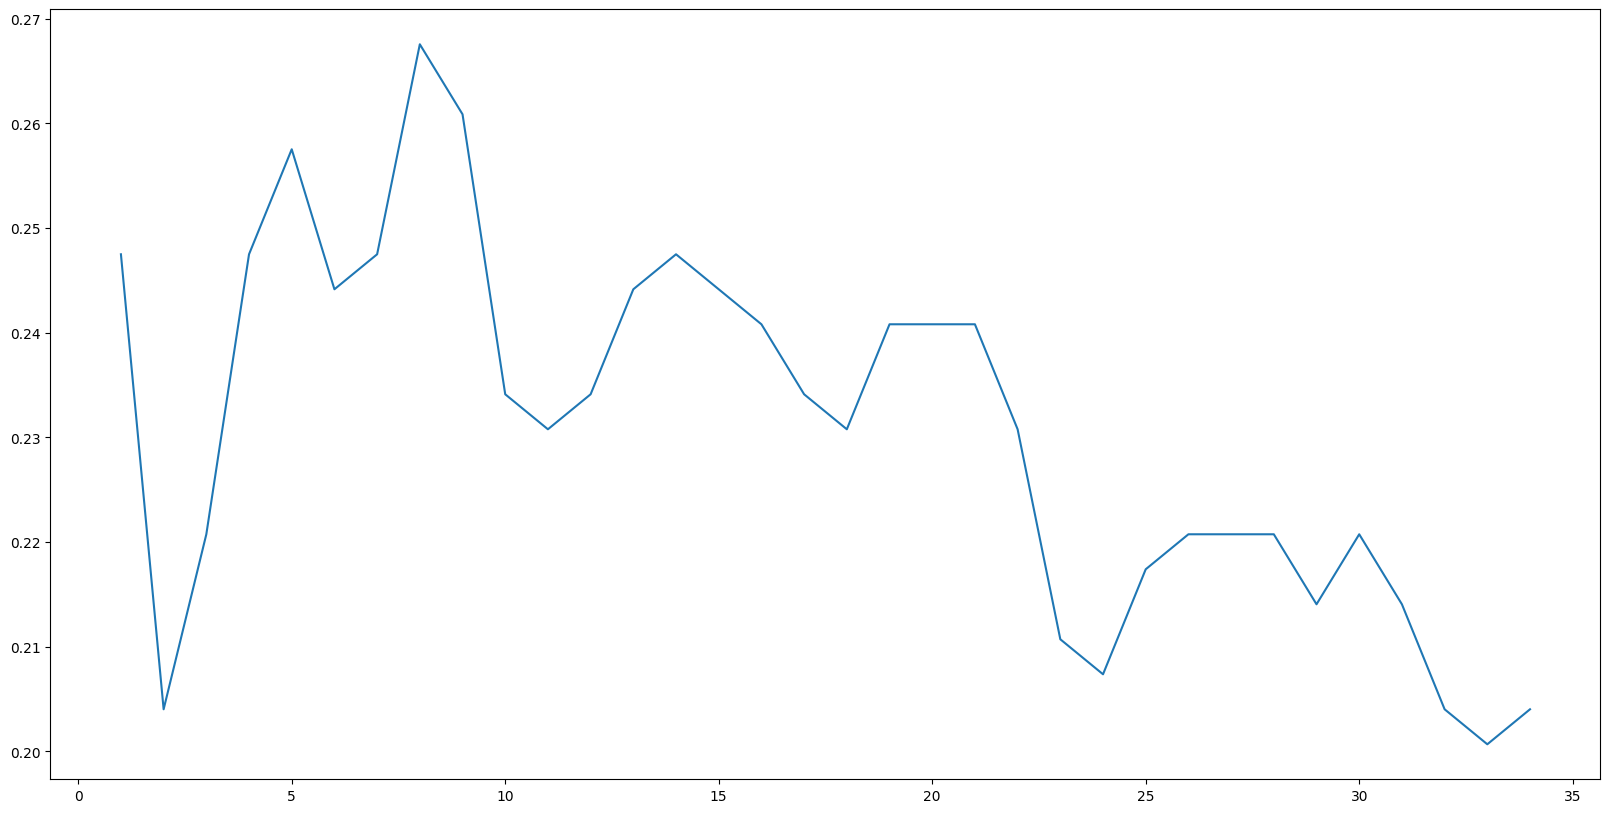

In [119]:
fig = plt.figure(figsize=(20, 10))
plt.plot(k_list, acc_list)
plt.show()

OPTIMIZATION

In [375]:
class Knn_optimized:
    def __init__(self, k, metric, encoding):
        self.k = k
        self.metric = metric
        self.encoding = encoding

    def predict(self, enc, train_data, validation_data):
        pred = []
        train_enc = []
        train_x = []

        for train in train_data:
            train_enc.append(train[enc][0])
            train_x.append(train[3])

        list_distance = []
        for test in validation_data:
            test = test[enc][0]
            distance = self.compute_distance(test, train_enc)
            label_pair = [[x, y] for x, y in zip(distance, train_x)]

            #list_distance.append([distance, train_x])
                
            label_pair.sort(key=lambda x: x[0])
            list_distance = label_pair[:self.k]
            train_labels = [x[1] for x in list_distance]
            pred.append(max(set(train_labels), key = train_labels.count))

        return pred

    def find_encoding(self):
        if self.encoding == 'ResNet':
            return 1
        return 2

    def compute_distance(self, test, train_enc):
        if self.metric == 'euclidean':
            diff = np.subtract(test, train_enc)
            distance = np.sqrt(np.sum(diff * diff, axis=1))
            return distance
        
        if self.metric == 'manhattan':
            diff = abs(np.subtract(test, train_enc))
            distance = np.sum(diff, axis=1)
            return distance
        
        if self.metric == 'cosine':
            dot_product = np.dot(train_enc, test)
            train_enc_magnitude = np.linalg.norm(train_enc)
            test_magnitude = np.linalg.norm(test)
            similarity = dot_product / (train_enc_magnitude * test_magnitude)
            return (1 - similarity)
        
    def print_scores(self, val, pred):
        print(accuracy_score(val, pred))
        print(f1_score(val, pred, average='macro'))
        print(precision_score(val, pred, average='macro', zero_division=0))
        print(recall_score(val, pred, average='macro', zero_division=0))

    def score(self, val, pred):
        return accuracy_score(val, pred)

In [376]:
prev = time.time()
prediction_optimized = Knn_optimized(17, metric='manhattan', encoding='VIT')
enc = prediction_optimized.find_encoding()
pred = prediction_optimized.predict(enc, train_data=train_data, validation_data=validation_data)
val = validation_data[:, 3]
prediction_optimized.print_scores(val, pred)
prediction_optimized.score(val, pred)
curr = time.time()
time_optimized = curr - prev

0.25752508361204013
0.1446197196197196
0.16868028743028743
0.15388513513513516


/home/siya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/siya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SK-LEARN KNN

In [377]:
train_data_new = []
for train in train_data:
    train_data_new.append(train[2][0])

validation_data_new = []
for validation in validation_data:
    validation_data_new.append(validation[2][0])

prev = time.time()
prediction_default = KNeighborsClassifier(n_neighbors=17, metric='manhattan')
prediction_default.fit(train_data_new, train_data[:, 3])
pred = prediction_default.predict(validation_data_new)
val = validation_data[:, 3]
print(accuracy_score(val, pred))
curr = time.time()
time_default = curr - prev

0.25418060200668896


INFERENCE TIME vs MODEL

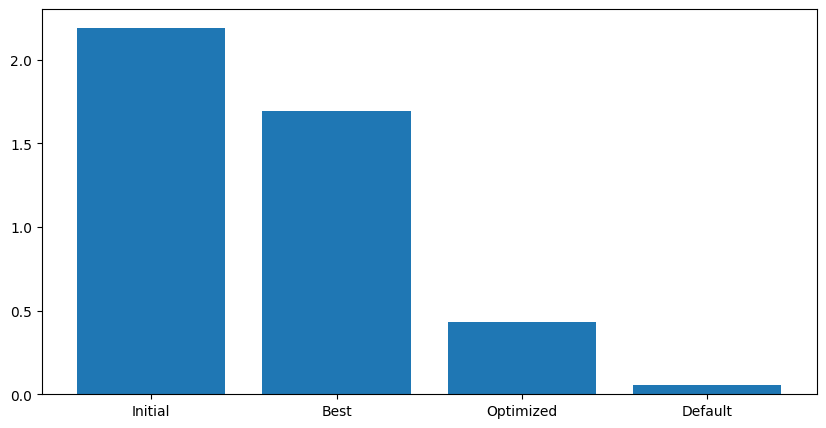

In [378]:
fig = plt.figure(figsize=(10, 5))
time_label = ['Initial', 'Best', 'Optimized', 'Default']
time_list = [time_initial, time_best, time_optimized, time_default]
plt.bar(time_label, time_list)
plt.show()

INFERENCE TIME vs DATASET SIZE

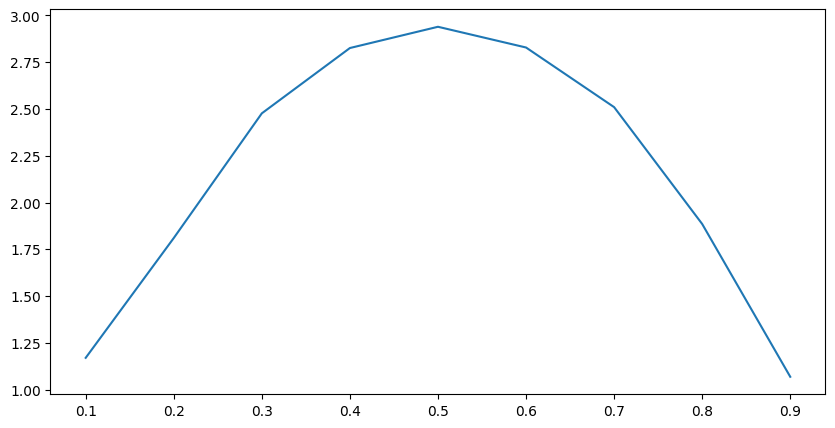

In [380]:
fig = plt.figure(figsize=(10, 5))
time_label = [0.1 * (i + 1) for i in range(9)]
time_list = []

for i in range(9):
    prev = time.time()
    prediction_initial = Knn(3, metric='euclidean', encoding='ResNet')
    enc = prediction_initial.find_encoding()

    size = math.floor(len(data) * 0.1 * (i + 1))
    train_data = data[0 : size - 1, :]
    validation_data = data[size : len(data) - 1, :]

    pred = prediction_initial.predict(enc, train_data=train_data, validation_data=validation_data)
    val = validation_data[:, 3]
    prediction_initial.score(val, pred)
    curr = time.time()
    time_list.append(curr - prev)

plt.plot(time_label, time_list)
plt.show()

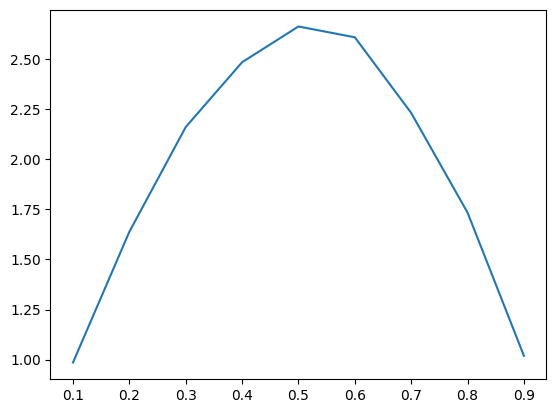

In [381]:
fig = plt.figure(figsize=(10, 5))
time_list = []

for i in range(9):
    prev = time.time()
    prediction_best = Knn(17, metric='manhattan', encoding='VIT')
    enc = prediction_best.find_encoding()

    size = math.floor(len(data) * 0.1 * (i + 1))
    train_data = data[0 : size - 1, :]
    validation_data = data[size : len(data) - 1, :]

    pred = prediction_best.predict(enc, train_data=train_data, validation_data=validation_data)
    val = validation_data[:, 3]
    prediction_best.score(val, pred)
    curr = time.time()
    time_list.append(curr - prev)

plt.plot(time_label, time_list)
plt.show()

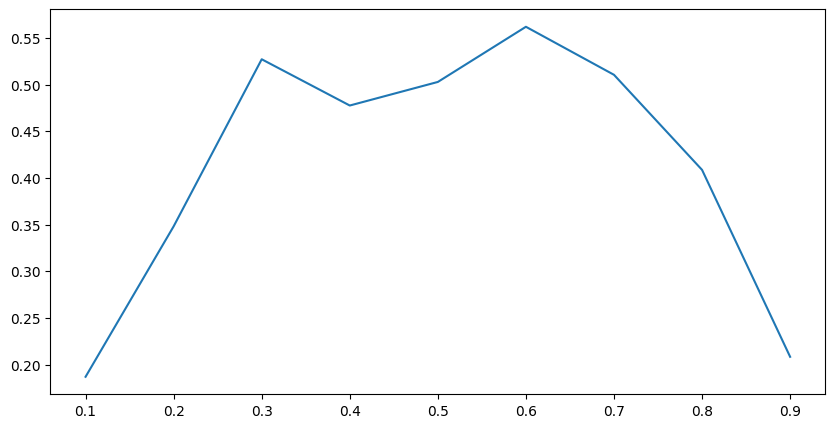

In [382]:
fig = plt.figure(figsize=(10, 5))
time_list = []

for i in range(9):
    prev = time.time()
    prediction_optimized = Knn_optimized(17, metric='manhattan', encoding='VIT')
    enc = prediction_optimized.find_encoding()

    size = math.floor(len(data) * 0.1 * (i + 1))
    train_data = data[0 : size - 1, :]
    validation_data = data[size : len(data) - 1, :]

    pred = prediction_optimized.predict(enc, train_data=train_data, validation_data=validation_data)
    val = validation_data[:, 3]
    prediction_optimized.score(val, pred)
    curr = time.time()
    time_list.append(curr - prev)

plt.plot(time_label, time_list)
plt.show()

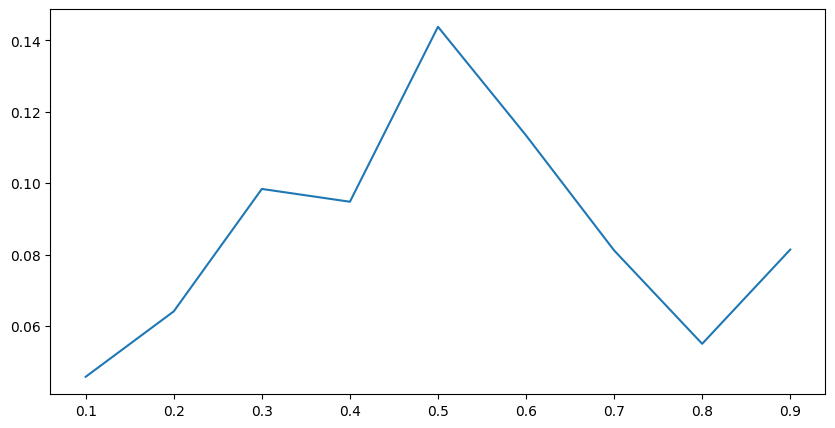

In [383]:
fig = plt.figure(figsize=(10, 5))
time_list = []

for i in range(9):
    prev = time.time()

    size = math.floor(len(data) * 0.1 * (i + 1))
    train_data = data[0 : size - 1, :]
    validation_data = data[size : len(data) - 1, :]

    train_data_new = []
    for train in train_data:
        train_data_new.append(train[2][0])

    validation_data_new = []
    for validation in validation_data:
        validation_data_new.append(validation[2][0])


    prediction_default = KNeighborsClassifier(n_neighbors=17, metric='manhattan')
    prediction_default.fit(train_data_new, train_data[:, 3])
    pred = prediction_default.predict(validation_data_new)
    val = validation_data[:, 3]

    curr = time.time()
    time_list.append(curr - prev)

plt.plot(time_label, time_list)
plt.show()

DECISION TREES

In [112]:
dataset = pd.read_csv('advertisement.csv')
labels_csv = dataset['labels']
labels_csv = list(labels_csv)

data_csv = dataset.drop(['labels'], axis=1)

ONE-HOT ENCODING

In [113]:
ohe = OneHotEncoder()
ohe.fit(data_csv)
ohe_data = ohe.transform(data_csv).toarray()

In [445]:
class DTC:
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion

        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

        self.pred = None
        self.f1_macro = None
    
    def split_data(self,train,label):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(train, label, test_size=0.2)
    
    def multioutputlabel(self, pred):
        for i in range(len(self.pred)):
            pred[i] = ''.join(str(self.pred[i][j]) for j in range(len(self.pred[i])))
        for i in range(len(self.y_test)):
            self.y_test[i] = ''.join(str(self.y_test[i][j]) for j in range(len(self.y_test[i])))

        return pred

    def predict_data(self):
        decision_tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        decision_tree.fit(self.x_train, self.y_train)
        pred = decision_tree.predict(self.x_test)
        return pred

    def scores1(self):   
        decision_tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        decision_tree.fit(self.x_train, self.y_train)
        pred = decision_tree.predict(self.x_test)

        acc = accuracy_score(self.y_test, pred)
        self.f1_macro = f1_score(self.y_test, pred, average='macro')
        f1_micro = f1_score(self.y_test, pred, average='micro')
        conf_matrix = confusion_matrix(self.y_test, pred)
        precision = precision_score(self.y_test, pred, average='macro', zero_division=0)
        recall = recall_score(self.y_test, pred, average='macro', zero_division=0)
                
        print([acc, self.f1_macro, f1_micro, conf_matrix, precision, recall, i, self.max_depth, self.max_features])

    def scores2(self):
        decision_tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        decision_tree.fit(self.x_train, self.y_train)
        pred = decision_tree.predict(self.x_test)

        pred = pred.astype(str)
        pred = [''.join(str(val) for val in row) for row in pred]
        self.y_test = [str(val) for val in self.y_test]
        self.y_test = [''.join(str(val) for val in row) for row in self.y_test]
        
        acc = accuracy_score(self.y_test, pred)
        self.f1_macro = f1_score(self.y_test, pred, average='macro')
        f1_micro = f1_score(self.y_test, pred, average='micro')
        conf_matrix = confusion_matrix(self.y_test, pred)
        precision = precision_score(self.y_test, pred, average='macro', zero_division=0)
        recall = recall_score(self.y_test, pred, average='macro', zero_division=0)
                
        print([acc, self.f1_macro, f1_micro, conf_matrix, precision, recall, i, self.max_depth, self.max_features])

POWERSET FORMULATION

In [437]:
def encode_labels(labels, power_set):
    encoded_labels = []
    for label in labels:
        label = label.split()
        label.sort()
        encoded_labels.append(power_set.index(label))
    return encoded_labels

set_labels = set()
for label in labels_csv:
    label = label.split()
    for l in label:
        set_labels.add(l)

power_set = list(itertools.chain.from_iterable(itertools.combinations(set_labels, r) for r in range(len(set_labels) + 1)))
power_set = [sorted(list(s)) for s in power_set]

encoded_labels = encode_labels(labels_csv, power_set)

dtc = DTC(max_depth=3, max_features=3, criterion='gini')
dtc.split_data(ohe_data, encoded_labels)
dtc.scores1()

[0.015, 0.0002736726874657909, 0.015, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 0.0001388888888888889, 0.009259259259259259, 'gini', 3, 3]


MULTIOUTPUT FORMULATION

In [446]:
mb = MultiLabelBinarizer(classes=list(set_labels))
encoded_labels_new = mb.fit_transform(dataset['labels'].str.split())

dtc = DTC(max_depth=3, max_features=3, criterion='gini')
dtc.split_data(ohe_data, encoded_labels)
dtc.scores2()

[0.01, 0.00017415534656913968, 0.01, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 8.796622097114708e-05, 0.008620689655172414, 'gini', 3, 3]


HYPERPARAMETER TUNING

In [447]:
criterion_list = ['gini', 'entropy']
max_depth_list = [3, 5, 10, 20, 30]
max_features_list = [3, 5, 7, 9, 11]

score_list = []
f1_list = []

for i in criterion_list:
    for depth in max_depth_list:
        for feature in max_features_list:  
            dtc = DTC(max_depth=depth, max_features=feature, criterion=i)
            dtc.split_data(ohe_data, encoded_labels)
            dtc.scores1()
            f1_list.append([dtc.f1_macro, i, depth, feature, 'PowerSet'])

for i in criterion_list:
    for depth in max_depth_list:
        for feature in max_features_list:  
            dtc = DTC(max_depth=depth, max_features=feature, criterion=i)
            dtc.split_data(ohe_data, encoded_labels)
            dtc.scores2()
            f1_list.append([dtc.f1_macro, i, depth, feature, 'MultiOutput'])


f1_list.sort(key=lambda x: x[0], reverse=True)
for l in f1_list[:3]:
    print(l)

[0.03, 0.0005201109570041609, 0.03, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 0.00026785714285714287, 0.008928571428571428, 'gini', 3, 3]
[0.015, 0.00026389866291344125, 0.015, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 0.00013392857142857144, 0.008928571428571428, 'gini', 3, 5]
[0.025, 0.003946337190539856, 0.025000000000000005, array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]]), 0.00472757910503651, 0.012232415902140673, 'gini', 3, 7]
[0.01, 0.0001917086029235562, 0.01, array([[0, 0, 0, ..., 0, 0, 0],
       [0,